In [1]:
# !python -m pip install plotnine

In [2]:
# !python -m pip install matplotlib-venn

In [3]:
import requests
import json
from pandas import json_normalize
import pandas as pd
import numpy as np
import re
from difflib import SequenceMatcher
import string
import itertools
from collections import Counter
from plotnine import ggplot, aes, geom_line, geom_point, geom_col, geom_bar, geom_density, geom_histogram, geom_hline, geom_vline, geom_text, theme, theme_minimal, theme_classic, labs, coord_flip, scale_fill_brewer, scale_color_manual, scale_x_discrete, scale_x_continuous, scale_y_continuous, position_stack, element_blank
from matplotlib_venn import venn2 
from matplotlib import pyplot as plt
import ast

In [4]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('max_colwidth')

In [5]:
data = pd.read_csv('songs_lyrics.csv')

In [6]:
data.shape

(27114, 8)

In [7]:
data.groupby('status_API').size()

status_API
200    27114
dtype: int64

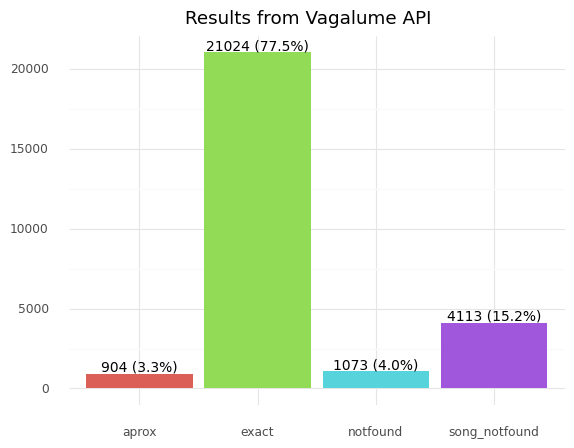

<ggplot: (675291073)>

In [8]:
res_api_df = data.groupby('res_API').size().reset_index(name="count")
res_api_df['perc'] = res_api_df['count']/res_api_df['count'].sum()
res_api_df['label'] = res_api_df.apply(lambda x: str(x['count']) + ' (' + str(round(x['perc']*100,1)) + '%)', axis=1)
# res_api_df.sort_values('count', inplace=True)
(
    ggplot(res_api_df)  
    + aes(x="res_API", y="count", label="label", fill="res_API") 
    + theme_minimal()
    + geom_col()  
    + geom_text(va="bottom", size=10)
    + labs(title='Results from Vagalume API',x='',y='')
    + theme(legend_position="none")
)

In [9]:
# Let's take a look at the 'aprox' results
data_aprox = pd.read_csv('songs_lyrics_aprox.csv')
data_aprox['similarity'] = data_aprox.apply(lambda x: SequenceMatcher(a=re.sub("\(.*?\)|\[.*?\]","",x['name'].lower()).translate(str.maketrans('','',string.punctuation)), 
                                                                      b=x['name_API'].lower().translate(str.maketrans('','',string.punctuation))).ratio(), axis=1) 
data_aprox[['artist','name','name_API','similarity']]

,artist,name,name_API,similarity
0,Gucci Mane,Big Booty,Big Booty (Ft. Megan Thee Stallion),0.439024
1,Jennifer Lopez,Booty,Booty (feat. Iggy Azalea),0.370370
2,Jason Derulo,Bubblegum,Bubblegum (Feat. Tyga),0.642857
3,Jason Derulo,Tip Toe,Tip Toe (Feat. French Montana),0.411765
4,Jason Derulo,Wiggle,Wiggle (Feat. Snoop Dogg),0.428571
...,...,...,...,...
899,Jo Dee Messina,Where Were You?,Where Were You,1.000000
900,Set It Off,Wolf In Sheep's Clothing,Wolf In Sheep's Clothing (Feat. William Beckett),0.686567
901,Beyoncé,My Power,"My Power (With Tierra Whack, Moonchild Sanelly...",0.280702
902,Kate Bush,"Oh England, My Lionheart",Oh England My Lionheart,1.000000


In [10]:
# There are some songs that are just not taking featurings from another artists in the title. 
# It is always inside (), so let's remove it and compare it once again
# We will also remove any punctuations and keep all lower case
data_aprox['name_API_wo_feat'] = data_aprox['name_API'].apply(lambda x: re.sub("\(.*?\)|\[.*?\]","",x))
data_aprox['similarity_wo_feat'] = data_aprox.apply(lambda x: SequenceMatcher(a=re.sub("\(.*?\)|\[.*?\]","",x['name'].lower()).translate(str.maketrans('','',string.punctuation)), 
                                                                              b=x['name_API_wo_feat'].lower().translate(str.maketrans('','',string.punctuation))).ratio(), axis=1) 
data_aprox[['artist','name','name_API_wo_feat','similarity_wo_feat']]

,artist,name,name_API_wo_feat,similarity_wo_feat
0,Gucci Mane,Big Booty,Big Booty,0.947368
1,Jennifer Lopez,Booty,Booty,0.909091
2,Jason Derulo,Bubblegum,Bubblegum,0.947368
3,Jason Derulo,Tip Toe,Tip Toe,0.933333
4,Jason Derulo,Wiggle,Wiggle,0.923077
...,...,...,...,...
899,Jo Dee Messina,Where Were You?,Where Were You,1.000000
900,Set It Off,Wolf In Sheep's Clothing,Wolf In Sheep's Clothing,0.978723
901,Beyoncé,My Power,My Power,0.941176
902,Kate Bush,"Oh England, My Lionheart",Oh England My Lionheart,1.000000


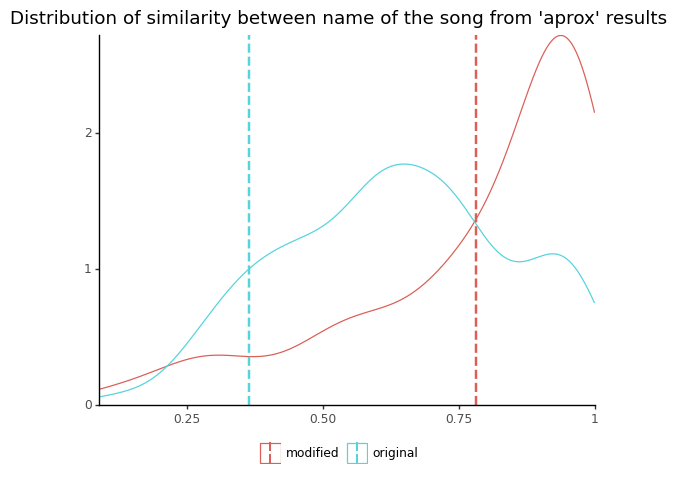

<ggplot: (675484682)>

In [11]:
similarity_stat = pd.DataFrame()
similarity_stat['stat'] = ['original','modified']
similarity_stat['value'] = [np.quantile(data_aprox['similarity'],0.05), np.quantile(data_aprox['similarity_wo_feat'],0.05)]
(
    ggplot(pd.concat([data_aprox.groupby('similarity_wo_feat').size().rename('n').reset_index().rename(columns={'similarity_wo_feat': 'similarity'}).assign(p_005='modified'),
                 data_aprox.groupby('similarity').size().rename('n').reset_index().assign(p_005='original')])) 
    + aes(x="similarity", color="p_005")  
    + theme_classic()
    + scale_y_continuous(expand=(0, 0, 0, 0))
    + scale_x_continuous(expand=(0, 0, 0, 0))
    + theme(legend_position = (0.5, 0.01),
            legend_title=element_blank())
    + geom_density() 
    + geom_vline(similarity_stat,aes(xintercept='value', colour='stat'), linetype='dashed', size=1)
    + labs(title="Distribution of similarity between name of the song from 'aprox' results",x='',y='')
)

In [12]:
# 5% of the songs are under 0.75 of similarity. This is a high value and to be safe, we will remove this 5%, which represents 45 songs.
# We also need to remove the songs that were not found, as there won't be any information to work with. 
index_to_delete = data_aprox[data_aprox['similarity_wo_feat']<np.quantile(data_aprox['similarity_wo_feat'],0.05)]['song_index'].values
data = data[~data['song_index'].isin(index_to_delete)]
data = data[data['res_API'].isin(['aprox','exact'])]
data.shape

(21883, 8)

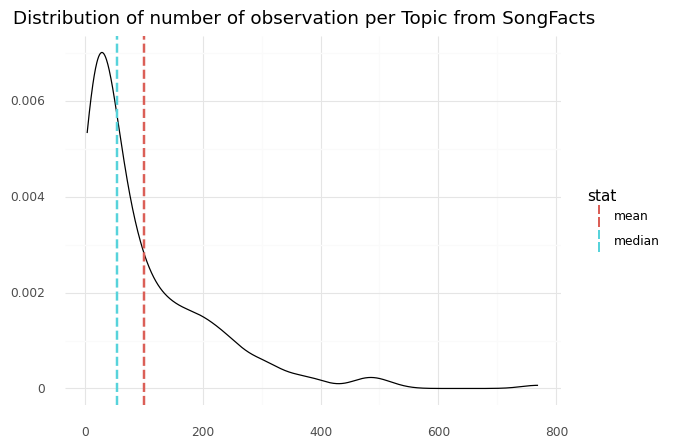

<ggplot: (675301118)>

In [13]:
count_topics_stat = pd.DataFrame()
count_topics_stat['stat'] = ['mean','median']
count_topics_stat['value'] = [data.groupby('topic').size().describe()['mean'], data.groupby('topic').size().describe()['50%']]

(
    ggplot(data.groupby('topic').size().rename('n').reset_index())  
    + aes(x="n")  
    + theme_minimal()
    + geom_density() 
    + geom_vline(count_topics_stat,aes(xintercept='value', colour='stat'), linetype='dashed', size=1)
    + labs(title='Distribution of number of observation per Topic from SongFacts',x='',y='')
)

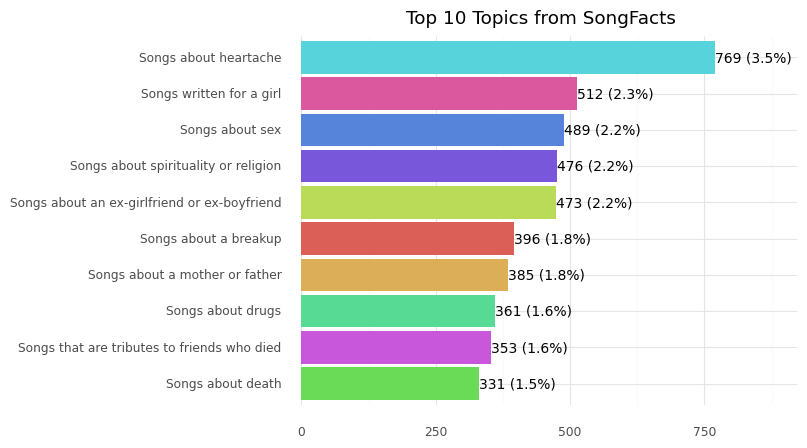

<ggplot: (675301136)>

In [14]:
topics_df = data.groupby('topic').size().reset_index(name="count")
topics_df['perc'] = topics_df['count']/topics_df['count'].sum()
topics_df['label'] = topics_df.apply(lambda x: str(x['count']) + ' (' + str(round(x['perc']*100,1)) + '%)', axis=1)
topics_df.sort_values('count', ascending=False, inplace=True)
(
    ggplot(topics_df.head(10))  
    + aes(x="topic", y="count", label="label", fill="topic")  
    + theme_minimal()
    + geom_col()  
    + geom_text(ha="left", size=10)
    + scale_x_discrete(limits=topics_df['topic'].tolist()[:10][::-1])
    + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title='Top 10 Topics from SongFacts',x='',y='')
    + coord_flip()
    + theme(legend_position="none") 
)

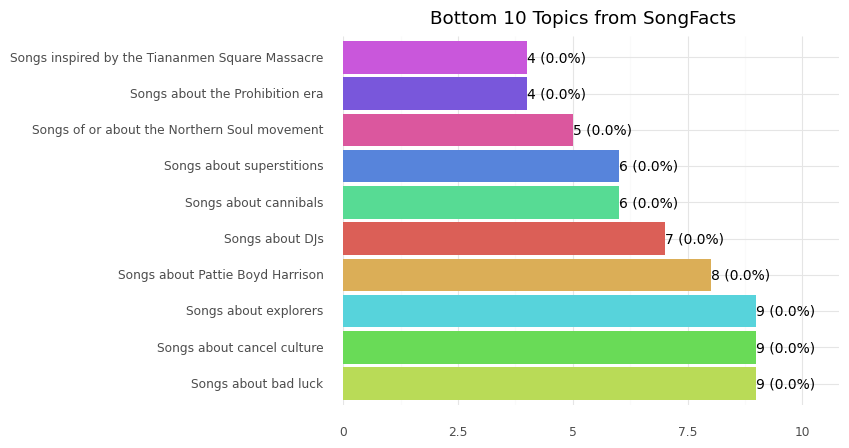

<ggplot: (675550106)>

In [15]:
topics_df = data.groupby('topic').size().reset_index(name="count")
topics_df['perc'] = topics_df['count']/topics_df['count'].sum()
topics_df['label'] = topics_df.apply(lambda x: str(x['count']) + ' (' + str(round(x['perc']*100,1)) + '%)', axis=1)
topics_df.sort_values('count', ascending=True, inplace=True)
(
    ggplot(topics_df.head(10))  
    + aes(x="topic", y="count", label="label", fill="topic")  
    + theme_minimal()
    + geom_col()  
    + geom_text(ha="left", size=10)
    + scale_x_discrete(limits=topics_df['topic'].tolist()[:10][::-1])
    + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title='Bottom 10 Topics from SongFacts',x='',y='')
    + coord_flip()
    + theme(legend_position="none") 
)

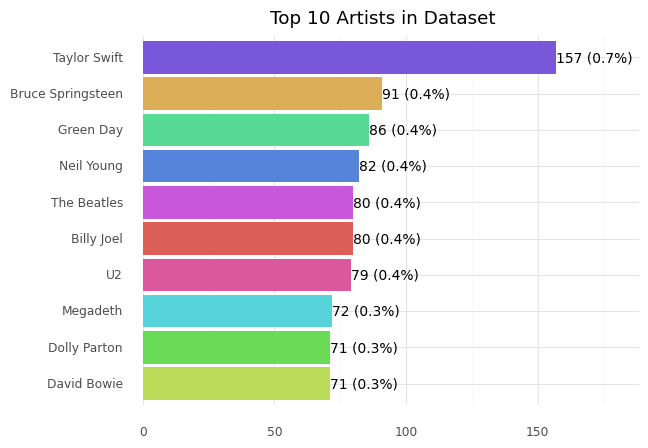

<ggplot: (675558977)>

In [16]:
artist_df = data.groupby('artist').size().reset_index(name="count")
artist_df['perc'] = artist_df['count']/artist_df['count'].sum()
artist_df['label'] = artist_df.apply(lambda x: str(x['count']) + ' (' + str(round(x['perc']*100,1)) + '%)', axis=1)
artist_df.sort_values('count', ascending=False, inplace=True)
(
    ggplot(artist_df.head(10))  
    + aes(x="artist", y="count", label="label", fill="artist")  
    + theme_minimal()
    + geom_col()  
    + geom_text(ha="left", size=10)
    + scale_x_discrete(limits=artist_df['artist'].tolist()[:10][::-1])
    + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title='Top 10 Artists in Dataset',x='',y='')
    + coord_flip()
    + theme(legend_position="none") 
)

In [17]:
# Are there songs with multiple labels?
topics_list_df = data.groupby(['artist','name'])['topic'].apply(list).reset_index(name='topics_list')
topics_list_df['n_list'] = topics_list_df['topics_list'].apply(lambda x: len(x))
topics_list_df[topics_list_df['n_list']>1].sort_values('n_list',ascending=False)

,artist,name,topics_list,n_list
15684,Taylor Swift,Epiphany,"[Songs about a grandparent, Songs about exhaus...",6
2234,Bon Jovi,Undivided,"[Songs about grieving, Songs about events in t...",5
16642,The Kinks,Do You Remember Walter?,"[Songs about childhood, Songs about friendship...",5
6000,Garth Brooks,Papa Loved Mama,"[Songs about affairs, Songs about being away f...",5
6691,Harvey Danger,Flagpole Sitta,"[Songs about being paranoid, Songs about being...",5
...,...,...,...,...
6467,Green Day,X-Kid,"[Songs about suicide, Songs that are tributes ...",2
6476,Gregory Porter,Take Me To The Alley,"[Songs about a mother or father, Songs about p...",2
6479,Gretchen Peters,Breakfast At Our House,"[Songs about marital problems or divorce, Song...",2
6481,Gretchen Peters,Imogene,"[Songs about high school experiences, Songs ab...",2


In [18]:
# The song with most topics is Epiphany by Taylor Swift
topics_list_df.sort_values('n_list',ascending=False).iloc[0]['topics_list']


['Songs about a grandparent',
 'Songs about exhaustion',
 'Songs about medical conditions',
 'Songs about pressure or burdens',
 'Songs about working',
 'Songs about war']

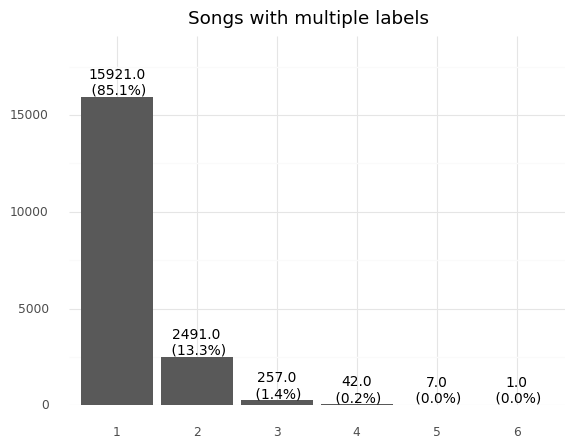

<ggplot: (675296422)>

In [19]:
more_than_one_topic_df = topics_list_df.groupby('n_list').size().reset_index(name="n")
more_than_one_topic_df['perc'] = more_than_one_topic_df['n']/more_than_one_topic_df['n'].sum()
more_than_one_topic_df['label'] = more_than_one_topic_df.apply(lambda x: str(x['n']) + '\n (' + str(round(x['perc']*100,1)) + '%)', axis=1)
(
    ggplot(more_than_one_topic_df)
    + aes(x="n_list", y="n", label="label")  
    + theme_minimal()
    + geom_col()  
    + geom_text(va="bottom",size=10)
    + scale_x_discrete(limits=more_than_one_topic_df['n_list'].tolist()[::1])
    + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title='Songs with multiple labels',x='',y='')
    + theme(legend_position="none") 
)

In [20]:
# Now we will take combinations of 2 to identify if there are any pair that is more common, and maybe belong together.
topics_list_df['topics_pair'] = topics_list_df.apply(lambda x: [list(i) for i in itertools.combinations(x['topics_list'], 2)], axis=1)
counter_list = Counter([str(i) for sublist in topics_list_df[topics_list_df['n_list']>1]['topics_pair'].values for i in sublist])
counter_list.most_common(10)

[("['Songs about a breakup', 'Songs about heartache']", 23),
 ("['Songs about fatherhood or motherhood', 'Songs written for a son or daughter']",
  23),
 ("['Songs about dependency or addiction', 'Songs about drugs']", 21),
 ("['Songs about alcohol', 'Songs about heartache']", 19),
 ("['Songs about specific musicians', 'Songs that are tributes to friends who died']",
  18),
 ("['Songs about a mother or father', 'Songs that are tributes to friends who died']",
  17),
 ("['Songs about people who committed crimes', 'Songs about serial killers']",
  14),
 ("['Songs about events in the news', 'Songs about racism or discrimination']",
  12),
 ("['Songs about animals', 'Songs about dogs']", 12),
 ("['Songs about an ex-girlfriend or ex-boyfriend', 'Songs about heartache']",
  12)]

In [21]:
# Getting intersections
for topic in data['topic'].unique():
    topics_list_df[topic] = topics_list_df.apply(lambda x: 1 if topic in x['topics_list'] else 0, axis=1)

In [22]:
counter_array = counter_list.most_common(10000)
counter_df = pd.DataFrame()
index_array = []
both_perc_array = []
n_songs_array = []
largest_topic_array = []
smaller_topic_array = []
n_largest_array = []
n_smallest_array = []
for index in range(len(counter_array)):
    if len(set(ast.literal_eval(counter_list.most_common(10000)[index][0])))>1:
        combination_labels = ast.literal_eval(counter_list.most_common(10000)[index][0])
        combination_df = topics_list_df[(topics_list_df[combination_labels[0]]==1) | (topics_list_df[combination_labels[1]]==1)][combination_labels]
        combination_df['both'] = combination_df.apply(lambda x: 1 if x[combination_labels[0]]==1 and x[combination_labels[1]]==1 else 0, axis=1)
        index_array.append(index)
        both_perc_array.append(round(combination_df.sum()['both']/combination_df.shape[0]*100,2))
        n_songs_array.append(combination_df.sum()['both'])
        largest_topic_array.append(combination_df[combination_labels].sum().sort_values(ascending=False).index[0])
        smaller_topic_array.append(combination_df[combination_labels].sum().sort_values(ascending=True).index[0])
        n_largest_array.append(combination_df[combination_labels].sum().sort_values(ascending=False)[0])
        n_smallest_array.append(combination_df[combination_labels].sum().sort_values(ascending=True)[0])

counter_df['index'] = index_array
counter_df['both_perc'] = both_perc_array
counter_df['n_songs'] = n_songs_array
counter_df['largest_topic'] = largest_topic_array
counter_df['smaller_topic'] = smaller_topic_array
counter_df['n_largest'] = n_largest_array
counter_df['n_smallest'] = n_smallest_array

In [23]:
counter_df.sort_values(by=['both_perc'], ascending=False)

,index,both_perc,n_songs,largest_topic,smaller_topic,n_largest,n_smallest
488,488,15.38,2,Songs about bad luck,Songs about superstitions,9,6
8,8,12.12,12,Songs about animals,Songs about dogs,90,21
198,198,9.38,3,Songs about fictional musicians,Songs about buskers or street musicians,23,12
1,1,9.24,23,Songs written for a son or daughter,Songs about fatherhood or motherhood,216,56
6,6,7.29,14,Songs about people who committed crimes,Songs about serial killers,185,21
...,...,...,...,...,...,...,...
1420,1421,0.10,1,Songs about heartache,Songs about dealing with fame,769,249
945,945,0.10,1,Songs about heartache,Songs about specific musicians,769,208
1442,1443,0.10,1,Songs about heartache,Songs about getting away,769,185
1291,1292,0.09,1,Songs about heartache,Songs about a mother or father,769,385


In [24]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

smallertopic_count_df = counter_df.groupby('smaller_topic').count().reset_index().sort_values('index', ascending=False)[['smaller_topic','largest_topic']]
largertopic_count_df = counter_df.groupby('largest_topic').count().reset_index().sort_values('index', ascending=False)[['largest_topic','smaller_topic']]
large_small_df = largertopic_count_df.merge(smallertopic_count_df, left_on='largest_topic', right_on='smaller_topic', how='left').drop('smaller_topic_y',axis=1)
large_small_df['which'] = large_small_df.apply(lambda x: 'large' if x['smaller_topic_x']>x['largest_topic_y'] 
                                               else 'large' if pd.isna(x['largest_topic_y']) 
                                               else 'small', axis=1)
large_small_df

,largest_topic_x,smaller_topic_x,largest_topic_y,which
0,Songs about heartache,69,NaN,large
1,Songs that are autobiographical,64,11.0,large
2,Songs about a mother or father,56,1.0,large
3,Songs about loneliness or isolation,56,11.0,large
4,Songs written for a girl,52,1.0,large
5,Songs about events in the news,50,7.0,large
6,Songs about a breakup,49,4.0,large
7,Songs about spirituality or religion,49,1.0,large
8,Songs about an ex-girlfriend or ex-boyfriend,47,3.0,large
9,Songs about places,46,3.0,large


In [25]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

labels_to_remove = set(counter_df['smaller_topic']) - set(large_small_df[large_small_df['which']=='large']['largest_topic_x'])
labels_to_remove_df = counter_df[(counter_df['smaller_topic'].isin(labels_to_remove)) & (~counter_df['largest_topic'].isin(labels_to_remove))]\
    .sort_values(['smaller_topic','both_perc'], ascending=[True, False])\
    .groupby('smaller_topic').agg({'n_smallest': 'max',
                                   'largest_topic': lambda x: list(x),
                                   'both_perc': lambda x: list(x)
                                   })\
    .reset_index()\
    .sort_values('n_smallest', ascending=False)

labels_to_remove_df['n_larger_topics'] = labels_to_remove_df['largest_topic'].apply(lambda x: len(x))
labels_to_remove_df


,smaller_topic,n_smallest,largest_topic,both_perc,n_larger_topics
114,Songs about regret,171,"[Songs about an ex-girlfriend or ex-boyfriend, Songs about dependency or addiction, Songs about a breakup, Songs about a mother or father, Songs about heartache, Songs about heartache, Songs about marital problems or divorce, Songs about war, Songs about death, Songs written for a girl, Songs about people who committed crimes, Songs about friendship, Songs about music, Songs about depression, Songs about being away from loved ones, Songs about cheating, Songs about loneliness or isolation, Songs that are autobiographical, Songs that are tributes to friends who died]","[0.94, 0.87, 0.71, 0.54, 0.53, 0.53, 0.48, 0.43, 0.4, 0.29, 0.28, 0.27, 0.25, 0.23, 0.23, 0.22, 0.21, 0.21, 0.19]",19
85,Songs about leaving the past behind,169,"[Songs about getting away, Songs about marital problems or divorce, Songs about a breakup, Songs about unhealthy relationships, Songs about friendship, Songs about perseverance, Songs about an ex-girlfriend or ex-boyfriend, Songs about change, Songs about getting older, Songs about dealing with fame, Songs about clubbing or a night out, Songs about confidence or courage, Songs about desire or longing, Songs about heartache, Songs about loneliness or isolation, Songs about events in the news, Songs that are autobiographical, Songs about heartache, Songs that are tributes to friends who died, Songs about a mother or father, Songs written for a girl]","[0.85, 0.72, 0.71, 0.54, 0.54, 0.51, 0.31, 0.27, 0.26, 0.24, 0.24, 0.24, 0.24, 0.21, 0.21, 0.21, 0.21, 0.21, 0.19, 0.18, 0.15]",21
90,Songs about looking back on fond memories,166,"[Songs that are autobiographical, Songs about getting older, Songs about change, Songs about an ex-girlfriend or ex-boyfriend, Songs about places, Songs about friendship, Songs about loneliness or isolation, Songs that are tributes to friends who died, Songs about music, Songs about a mother or father, Songs about getting away, Songs about political figures, Songs about joy and happiness, Songs about alcohol, Songs about finding love, Songs about heartache, Songs about heartache, Songs about death, Songs about a breakup, Songs about sex, Songs written for a girl]","[2.42, 1.6, 1.1, 0.95, 0.86, 0.82, 0.65, 0.58, 0.51, 0.36, 0.29, 0.29, 0.28, 0.25, 0.24, 0.21, 0.21, 0.2, 0.18, 0.15, 0.15]",21
51,Songs about dancing,165,"[Songs about clubbing or a night out, Songs about historical events, Songs written for a girl, Songs about individuality, Songs about joy and happiness, Songs about medical conditions, Songs about desire or longing, Songs about confidence or courage, Songs about finding love, Songs about loneliness or isolation, Songs about a mother or father, Songs about sex]","[1.49, 0.55, 0.3, 0.28, 0.28, 0.27, 0.25, 0.24, 0.24, 0.21, 0.18, 0.15]",12
88,Songs about living in the moment,153,"[Songs about finding love, Songs about medical conditions, Songs about perseverance, Songs written for a son or daughter, Songs about getting older, Songs about clubbing or a night out, Songs about depression, Songs about events in the news, Songs that are autobiographical, Songs about sex]","[0.73, 0.28, 0.27, 0.27, 0.27, 0.25, 0.24, 0.22, 0.22, 0.16]",10
47,Songs about commitment or respect,148,"[Songs about cheating, Songs written for a girl, Songs about friendship, Songs about dealing with fame, Songs that are autobiographical, Songs about death, Songs about spirituality or religion]","[0.95, 0.46, 0.29, 0.25, 0.22, 0.21, 0.16]",7
133,Songs about suicide,142,"[Songs that are tributes to friends who died, Songs about depression, Songs about dependency or addiction, Songs about death, Songs about medical conditions, Songs about marital problems or divorce, Songs about dealing with fame, Songs about alcohol, Songs about war, Songs about loneliness or isolation, Songs about events in the news, Songs about drugs, Songs about heartache]","[1.85, 1.01, 0.63, 0.42, 0.29, 0.26, 0.26, 0.26, 0.23, 0.23, 0.23, 

In [26]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('max_colwidth')

In [27]:
data.groupby(["name","artist"]).count().reset_index().shape

(18719, 8)

In [28]:
data[~data['topic'].isin(labels_to_remove)].groupby(["name","artist"]).count().reset_index().shape

(12948, 8)

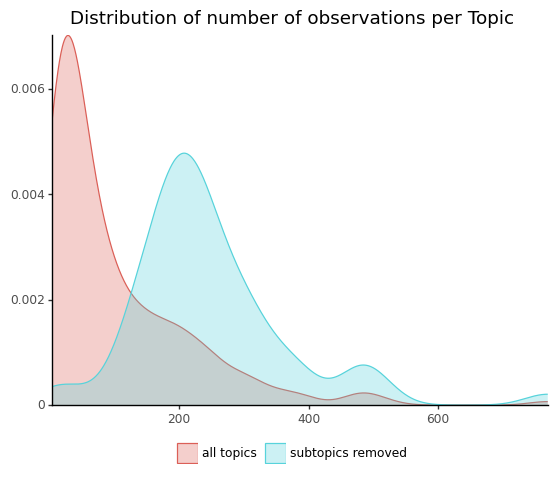

<ggplot: (676061539)>

In [29]:
data_full = data.groupby('topic').size().rename('n').reset_index()
data_full['source'] = 'all topics'
data_largeonly = data[~data['topic'].isin(labels_to_remove)].groupby('topic').size().rename('n').reset_index()
data_largeonly['source'] = 'subtopics removed'

(
    ggplot(pd.concat([data_full, data_largeonly]))  
    + aes(x="n", color="source", fill="source")  
    + theme_classic()
    + geom_density(alpha=0.3) 
    + scale_y_continuous(expand=(0, 0, 0, 0))
    + scale_x_continuous(expand=(0, 0, 0, 0))
    + labs(title='Distribution of number of observations per Topic',x='',y='')
    + theme(legend_position = (0.5, 0.01),
            legend_title=element_blank())
)

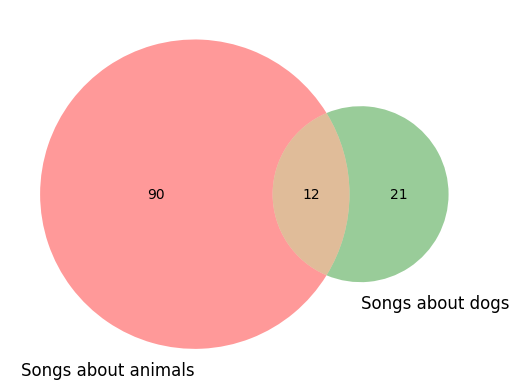

In [30]:
combination_labels = ast.literal_eval(counter_list.most_common(10000)[8][0])
combination_df = topics_list_df[(topics_list_df[combination_labels[0]]==1) | (topics_list_df[combination_labels[1]]==1)][combination_labels]
combination_df['both'] = combination_df.apply(lambda x: 1 if x[combination_labels[0]]==1 and x[combination_labels[1]]==1 else 0, axis=1)
venn2(subsets = combination_df.sum().values, set_labels = combination_labels)
plt.show()

In [31]:
data = data.merge(topics_list_df, on=['artist','name'], how='left')

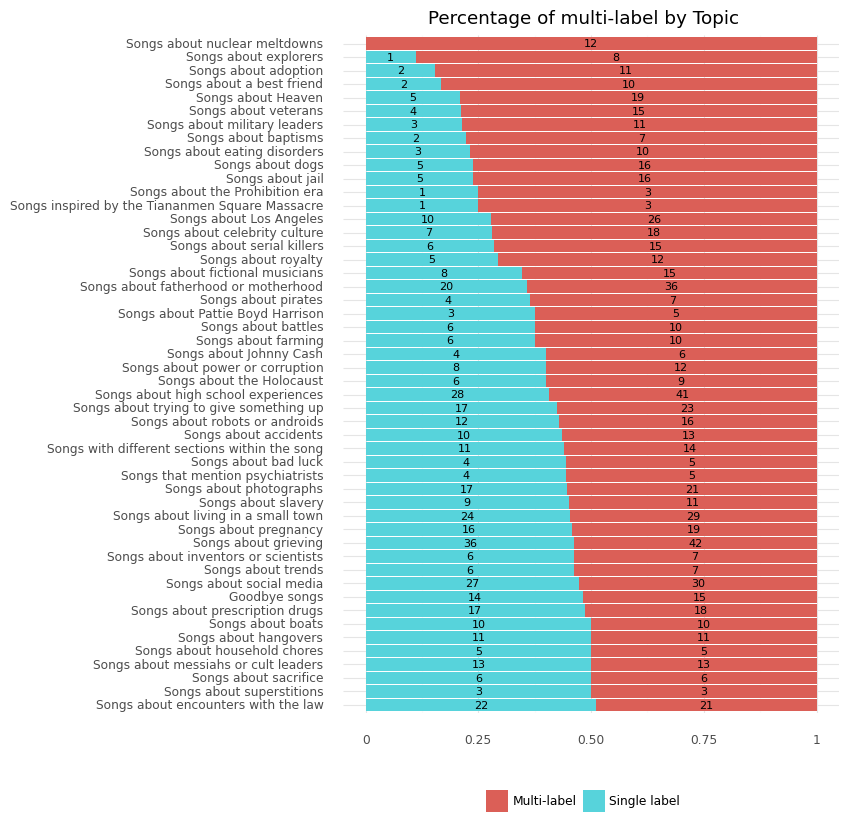

<ggplot: (675490651)>

In [40]:
data['has_more_than_one_topic'] = data['n_list'].apply(lambda x: '1' if x>1 else '0')
perc_more_topic_df = data.groupby(['topic','has_more_than_one_topic']).size().reset_index(name="count")
perc_more_topic_df['perc'] = perc_more_topic_df['count']/perc_more_topic_df.groupby('topic')['count'].transform('sum')
perc_more_topic_df['label'] = perc_more_topic_df.apply(lambda x: round(x['perc'],2), axis=1)
perc_more_topic_df.sort_values(['has_more_than_one_topic','perc'], ascending=False, inplace=True)
perc_more_topic_df['has_more_than_one_topic_n'] = perc_more_topic_df['has_more_than_one_topic'].apply(lambda x: 'Multi-label' if x=='1' else 'Single label')
(
    ggplot(perc_more_topic_df[perc_more_topic_df['topic'].isin(perc_more_topic_df.head(50).topic)])  
    + aes(x="topic", y="perc", label="count", fill="has_more_than_one_topic_n") 
    + theme_minimal()
    + geom_col(position = "fill")  
    + geom_text(size=8, position = position_stack(vjust = .5))
    + scale_x_discrete(limits=perc_more_topic_df['topic'].tolist()[:50][::-1])
    + coord_flip()
    + labs(title='Percentage of multi-label by Topic',x='',y='')
    + theme(figure_size=(6.4, 8.8),
            legend_position = (0.5, 0.01),
            legend_title=element_blank())
)

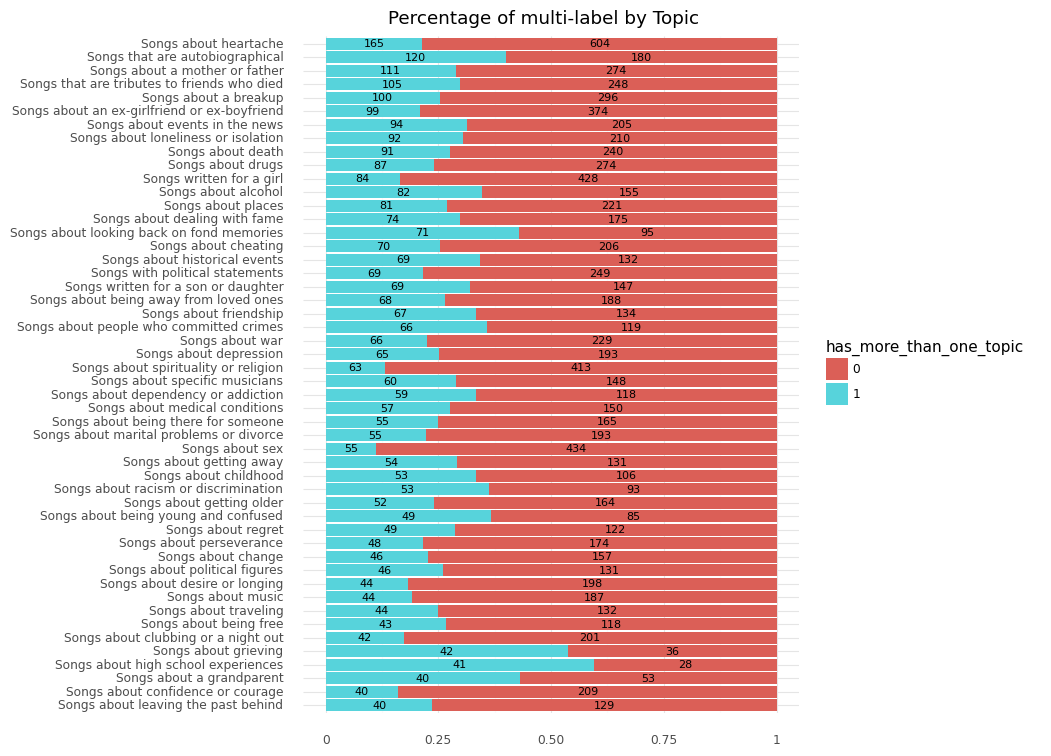

<ggplot: (672405144)>

In [107]:
data['has_more_than_one_topic'] = data['n_list'].apply(lambda x: '1' if x>1 else '0')
perc_more_topic_df = data.groupby(['topic','has_more_than_one_topic']).size().reset_index(name="count")
perc_more_topic_df['perc'] = perc_more_topic_df['count']/perc_more_topic_df.groupby('topic')['count'].transform('sum')
perc_more_topic_df['label'] = perc_more_topic_df.apply(lambda x: round(x['perc'],2), axis=1)
perc_more_topic_df.sort_values(['has_more_than_one_topic','count'], ascending=False, inplace=True)
(
    ggplot(perc_more_topic_df[perc_more_topic_df['topic'].isin(perc_more_topic_df.head(50).topic)])  
    + aes(x="topic", y="perc", label="count", fill="has_more_than_one_topic") 
    + theme_minimal()
    + geom_col(position = "fill")  
    + geom_text(size=8, position = position_stack(vjust = .5))
    + scale_x_discrete(limits=perc_more_topic_df['topic'].tolist()[:50][::-1])
    + coord_flip()
    + labs(title='Percentage of multi-label by Topic',x='',y='')
    + theme(figure_size=(6.4, 8.8))
)

In [108]:
perc_more_topic_df[(perc_more_topic_df['has_more_than_one_topic']=='0') & (perc_more_topic_df['perc']>0.7)]

,topic,has_more_than_one_topic,count,perc,label
202,Songs about heartache,0,604,0.785436,0.79
333,Songs about sex,0,434,0.887526,0.89
424,Songs written for a girl,0,428,0.835938,0.84
347,Songs about spirituality or religion,0,413,0.867647,0.87
54,Songs about an ex-girlfriend or ex-boyfriend,0,374,0.790698,0.79
...,...,...,...,...,...
32,Songs about a circus or carnival,0,14,0.736842,0.74
176,Songs about fighting,0,12,0.705882,0.71
104,Songs about censorship,0,8,0.727273,0.73
14,Songs about DJs,0,5,0.714286,0.71


In [109]:
topics = data.groupby('topic').size().reset_index(name='n').sort_values('n',ascending=False).topic.values
total_n = data.shape[0]
count_n = 0
count_topics_n = pd.DataFrame()
for i in range(len(topics)):
    n_topic = data[data['topic']==topics[i]].shape[0]
    count_n += n_topic
    share_topic = count_n/total_n
    count_topics_n=pd.concat([count_topics_n,pd.DataFrame({'n': [i+1],
                 'share': [share_topic]
                })])

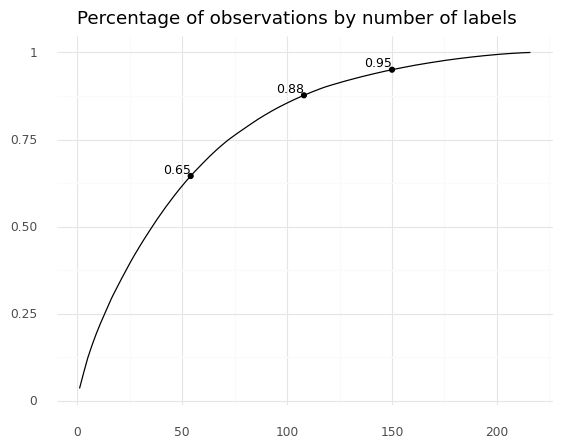

<ggplot: (674512059)>

In [110]:
(
    ggplot(count_topics_n)
    + aes(x="n", y="share")  
    + theme_minimal()
    + geom_line() 
    + geom_point(count_topics_n[count_topics_n['n'].isin([54,108,150])])
    + geom_text(count_topics_n[count_topics_n['n'].isin([54,108,150])], aes(label='np.round(share,2)'), va="bottom",ha="right", size=9)
    + labs(title='Percentage of observations by number of labels',x='',y='')
)

In [111]:
# Now let's try to find a threshold to remove any topic that by itself only has this amount of songs
count_topics_remove = pd.DataFrame()
for i in range(0,100):
    topics_to_remove = perc_more_topic_df[(perc_more_topic_df['has_more_than_one_topic']=='0') & (perc_more_topic_df['count']<i)].topic.values
    share_remaining = (data.shape[0] - data[data['topic'].isin(topics_to_remove)].shape[0])/data.shape[0]
    count_topics_remove=pd.concat([count_topics_remove,pd.DataFrame({'n': [i],
                 'share': [share_remaining]
                })])

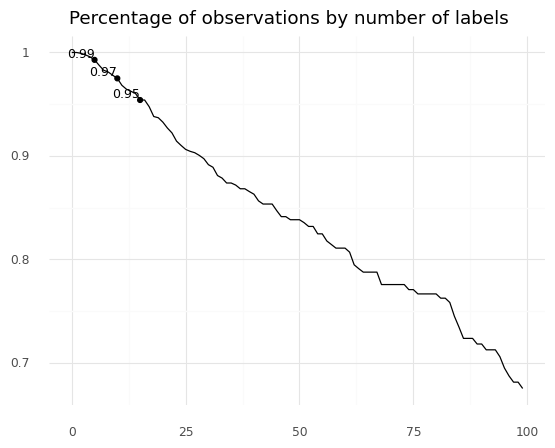

<ggplot: (674517566)>

In [112]:
(
    ggplot(count_topics_remove)
    + aes(x="n", y="share")  
    + theme_minimal()
    + geom_line() 
    + geom_point(count_topics_remove[count_topics_remove['n'].isin([5,10,15])])
    + geom_text(count_topics_remove[count_topics_remove['n'].isin([5,10,15])], aes(label='np.round(share,2)'), va="bottom",ha="right", size=9)
    + labs(title='Percentage of observations by number of labels',x='',y='')
)

In [113]:
data.to_csv('songs_lyrics_post_eda.csv')
data[~data['topic'].isin(labels_to_remove)].to_csv('songs_lyrics_training.csv')